# <div class="alert alert-info"> 1. Introduction </div>

Text Classification is the task of assigning predefined categories to a document to help find the information or simplify some activities. For example, an application of text classification is spam filtering in email

There are a wide variety of techniques for classifying text documents, and depend on the classification models, the corresponding text processing and feature engineering is chosen. This analysis applies different techniques and go through the whole process for NLP classification analsysis including the following tasks:

1. Data Preparation and cleansing
2. Data Visualization
3. Text Preprocessing and Normalization
4. Feature Geneartion
5. Text Classification: apply 4 approaches
    + Traditional supervised Machine Learning models
    + Newer supervised Deep Learning models
    + Advanced supervised Deep Learning models
    + State-of-the-art Deep Learning models in NLP

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>2.1. install library</font>

 ## <font color=red>2.2. Import library</font>

In [1]:
import sys
import sklearn
import pandas as pd
import numpy as np

## for data
import collections
import json

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing text
import spacy
nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import string
import re
from bs4 import BeautifulSoup
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# for classification
from sklearn import feature_selection, feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

## for sentiment analysis
from textblob import TextBlob

## for bert language model
import transformers

# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# display various ranges 
pd.options.display.float_format = '{:.3f}'.format

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print("Setup complete...")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
NLTK: 3.6.5
Scikit-learn: 0.23.2
Pandas: 1.3.3
Numpy: 1.21.2
Setup complete...


---
# <div class="alert alert-info"> 3. Data Preparation </div>

 ## <font color=red>**3.1.  News category dataset**

The dataset used is “News category dataset” from Kaggle (https://www.kaggle.com/rmisra/news-category-dataset. This dataset provided with around 200k news headlines from the year 2012 to 2018 obtained from HuffPost.

## <font color=red>3.2. Load data
    
The dataset is contained into a json file, so I will first read it into a list of dictionaries with json and then transform it into a pandas Dataframe.

In [2]:
def read_jsonfile(path):   
    lst_dics = []
    with open(path, mode='r', errors='ignore') as json_file:
        for dic in json_file:
            lst_dics.append(json.loads(dic))
    
    return lst_dics
    
lst_dics = read_jsonfile('News_Category_Dataset_v2.json')
# create data frame
df = pd.DataFrame(lst_dics)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
df.category.nunique(),  df.shape

(41, (200853, 6))

 ## <font color=red> Data Cleansing

The following 3 tasks are applied:

+ The original dataset contains over 30 categories, but for the purposes of this tutorial, I will work with a subset of 2: BUSINESS, SPORTS. Field text is created to combine  field headline and short_description

+ Select columns of interest: category, headline, short_description

+ Only select text written in English

+ Create new column 'text' which is the combination of 'headline' and 'short_description'. This column is used as input for classification model

+ Rename column:  rename target var from 'category' to 'y'

In [3]:
import langdetect

# select values for target var
selected_target = ['BUSINESS','SPORTS']
selected_columns = ['category','headline','short_description']
column_name_mapping = {'category': 'y'}

def data_preparation(data, selected_target, selected_columns, column_name_mapping):
    # select valid rows
    data = data[data["category"].isin(selected_target)]
    
    # select valid columns
    data = data[selected_columns]
    
    # filter language
    data['lang'] = data['headline'].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
    print('Number of lang: ', data.lang.nunique())
    data = data[data["lang"]=="en"]
    
    # combine columns
    data['text'] = df['headline'] + '. '+ data['short_description']
    
    # rename column
    for e in column_name_mapping:
        data.rename(columns=column_name_mapping, inplace=True)
    
    #  reset data
    data = data.reset_index(drop=True)
            
    return data
               
df = data_preparation(df, selected_target, selected_columns, column_name_mapping)
print('Data size after cleansing and prepparation',df.shape)
print('Print 5 random samples:')
df.sample(5)

Number of lang:  25
Data size after cleansing and prepparation (10358, 5)
Print 5 random samples:


,y,headline,short_description,lang,text
9551,BUSINESS,Paul Krugman: GOP Fiscal Cliff Offer 'Pathetic',"""The ball really is with them now,"" Geithner s...",en,Paul Krugman: GOP Fiscal Cliff Offer 'Pathetic...
5697,BUSINESS,Is There Truth in the Statement That ALL Nonpr...,"Many nonprofit boards, managers and staff figu...",en,Is There Truth in the Statement That ALL Nonpr...
7647,BUSINESS,Is Your Nonprofit Board Chair Productive?,,en,Is Your Nonprofit Board Chair Productive?.
9439,BUSINESS,OPEC's Massive $1 Trillion Haul in 2012 While ...,"This torrent of money flowing into OPEC, espec...",en,OPEC's Massive $1 Trillion Haul in 2012 While ...
1047,SPORTS,FIFA: Trump's Travel Ban Could Hurt U.S. Effor...,"Teams and fans ""need to have access to the cou...",en,FIFA: Trump's Travel Ban Could Hurt U.S. Effor...


In [4]:
df.head()

,y,headline,short_description,lang,text
0,SPORTS,Jets Chairman Christopher Johnson Won't Fine P...,“I never want to put restrictions on the speec...,en,Jets Chairman Christopher Johnson Won't Fine P...
1,BUSINESS,"U.S. Launches Auto Import Probe, China Vows To...",The investigation could lead to new U.S. tarif...,en,"U.S. Launches Auto Import Probe, China Vows To..."
2,SPORTS,Trump Posthumously Pardons Boxer Jack Johnson,The pardoning of the black heavyweight boxer i...,en,Trump Posthumously Pardons Boxer Jack Johnson....
3,SPORTS,Anna Kournikova Dancing With Her Bouncing Baby...,The score is love-love.,en,Anna Kournikova Dancing With Her Bouncing Baby...
4,SPORTS,Trump Says NFL Players Unwilling To Stand For ...,"""I don’t think people should be staying in loc...",en,Trump Says NFL Players Unwilling To Stand For ...


## <font color=red>**Text Processing and Normalizing** </font>  
    
Before feature engineering, we need to  pre-process, clean, and normalize text. Following are some of the popular pre-processing techniques:

**1. Text tokenization and lower casting**: Split doc into individual words and lower casting all words <br>
**2. Removing special characters**: remove special characters and punctuations <br>
**3. Removing stop words**: Words like "a" and "the" appear so frequently and  are called stop words, they can be filtered from the text to be processed <br>
**4. Stemming**: extract root of words by remove -ing, -ly, -ed... <br>
**5. Lemmatization**: In contrast to stemming, lemmatization looks beyond word reduction, and considers a language's full vocabulary to apply a *morphological analysis* to words. The lemma of 'was' is 'be' and the lemma of 'mice' is 'mouse'. Further, the lemma of 'meeting' might be 'meet' or 'meeting' depending on its use in a sentence. <br>

In [5]:
def normalize_text(text, flg_stemm=False, flg_lemm=False, lst_stopwords=None):
    
    ## clean (convert to lowercase and remove punctuations and   characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub('[^a-zA-Z\s]', '', text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    
    return text

Create a list of generic stop words for the English vocabulary with nltk (we could edit this list by adding or removing words).

In [6]:
lst_stopwords = nltk.corpus.stopwords.words("english")

Apply normalizing text to each row and store the result in a new column named “text_clean” so that it can be used as the raw corpus or the preprocessed text.

In [7]:
df["text_clean"] = df["text"].apply(lambda x: normalize_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=lst_stopwords))

df.head()

,y,headline,short_description,lang,text,text_clean
0,SPORTS,Jets Chairman Christopher Johnson Won't Fine P...,“I never want to put restrictions on the speec...,en,Jets Chairman Christopher Johnson Won't Fine P...,jet chairman christoph johnson wont fine playe...
1,BUSINESS,"U.S. Launches Auto Import Probe, China Vows To...",The investigation could lead to new U.S. tarif...,en,"U.S. Launches Auto Import Probe, China Vows To...",u launch auto import probe china vow defend in...
2,SPORTS,Trump Posthumously Pardons Boxer Jack Johnson,The pardoning of the black heavyweight boxer i...,en,Trump Posthumously Pardons Boxer Jack Johnson....,trump posthum pardon boxer jack johnson pardon...
3,SPORTS,Anna Kournikova Dancing With Her Bouncing Baby...,The score is love-love.,en,Anna Kournikova Dancing With Her Bouncing Baby...,anna kournikova danc bounc babi cutest thing s...
4,SPORTS,Trump Says NFL Players Unwilling To Stand For ...,"""I don’t think people should be staying in loc...",en,Trump Says NFL Players Unwilling To Stand For ...,trump say nfl player unwil stand anthem mayb s...


## <font color=red>**Split data** </font>  

In [8]:
def data_splitting(data, y, test_size=0.3, shuffle=False):
    
    data_train, data_test = model_selection.train_test_split(data, test_size=test_size, shuffle=shuffle)
    print("X_train shape:", data_train.drop(y, axis=1).shape, "| X_test shape:", data_test.drop(y, axis=1).shape)
    print("y:")
    for i in data_train["y"].value_counts(normalize=True).index:
        print(" ", i, " ---> train:", round(data_train["y"].value_counts(normalize=True).loc[i], 2),
                          "| test:", round(data_test["y"].value_counts(normalize=True).loc[i], 2))
    data_train = data_train.reset_index(drop=True)    
    data_test = data_test.reset_index(drop=True) 
    
    return data_train, data_test

# split data
df_train, df_test = data_splitting(df, y="y", test_size=0.3, shuffle=False)
y_train = df_train['y']
y_test = df_test['y']

X_train shape: (7250, 5) | X_test shape: (3108, 5)
y:
  SPORTS  ---> train: 0.51 | test: 0.32
  BUSINESS  ---> train: 0.49 | test: 0.68


---
# <div class="alert alert-info"> 4. Data Exploration </div>

## <font color=red> distribution of word_count in each class

In [10]:
df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split(" ")))

df.head()

,y,headline,short_description,lang,text,text_clean,word_count
0,SPORTS,Jets Chairman Christopher Johnson Won't Fine P...,“I never want to put restrictions on the speec...,en,Jets Chairman Christopher Johnson Won't Fine P...,jet chairman christoph johnson wont fine playe...,15
1,BUSINESS,"U.S. Launches Auto Import Probe, China Vows To...",The investigation could lead to new U.S. tarif...,en,"U.S. Launches Auto Import Probe, China Vows To...",u launch auto import probe china vow defend in...,21
2,SPORTS,Trump Posthumously Pardons Boxer Jack Johnson,The pardoning of the black heavyweight boxer i...,en,Trump Posthumously Pardons Boxer Jack Johnson....,trump posthum pardon boxer jack johnson pardon...,15
3,SPORTS,Anna Kournikova Dancing With Her Bouncing Baby...,The score is love-love.,en,Anna Kournikova Dancing With Her Bouncing Baby...,anna kournikova danc bounc babi cutest thing s...,9
4,SPORTS,Trump Says NFL Players Unwilling To Stand For ...,"""I don’t think people should be staying in loc...",en,Trump Says NFL Players Unwilling To Stand For ...,trump say nfl player unwil stand anthem mayb s...,26


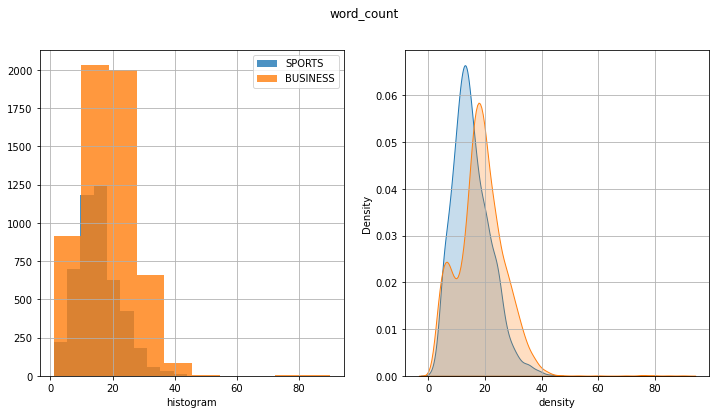

In [11]:
x, y = "word_count",  "y"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle(x, fontsize=12)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, bins=10, 
                 hist_kws={"alpha":0.8}, axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True,
                 kde_kws={"shade":True},  axlabel="density", ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

## <font color=red> top 10 frequency words in each class

# SPORTS:


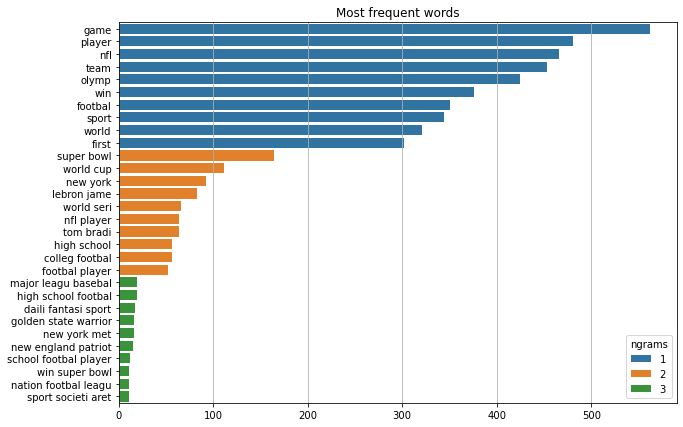

# BUSINESS:


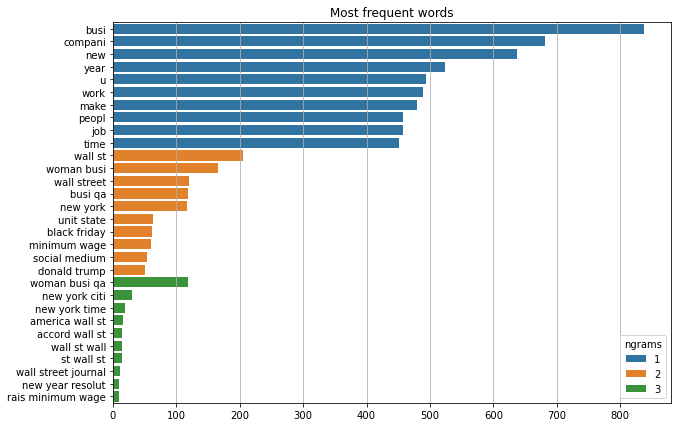

In [12]:
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

df_freq = pd.DataFrame()
for y in df["y"].unique():
    print("# {}:".format(y))
    df_y = word_freq(corpus=df[df["y"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    df_y["y"] = y
    df_freq = df_freq.append(df_y)

## <font color=red>word cloud of each class

# SPORTS:


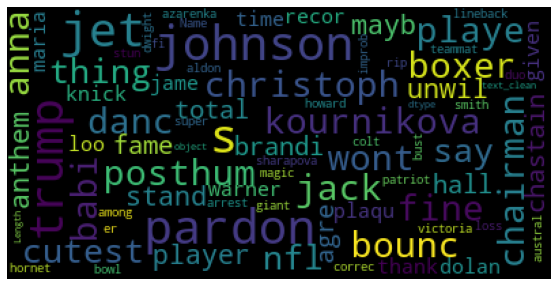

# BUSINESS:


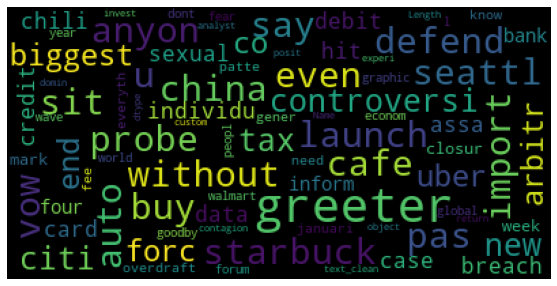

In [13]:
import wordcloud

def plot_wordcloud(corpus, max_words=150, max_font_size=35, figsize=(10,10)):
    wc = wordcloud.WordCloud(background_color='black', max_words=max_words, max_font_size=max_font_size)
    wc = wc.generate(str(corpus)) #if type(corpus) is not dict else wc.generate_from_frequencies(corpus)     
    fig = plt.figure(num=1, figsize=figsize)
    plt.axis('off')
    plt.imshow(wc, cmap=None)
    plt.show()

    
for y in df["y"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=df[df["y"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

---
# <div class="alert alert-info">5. Classification 1: Traditional  supervised ML models
    
In this approach, the following techniques will be applied:
    
1. **Step 1 - Feature Engineering**: feature engineering technique is based on Frequency-based word embedding which includes the Bag of Words model or the tf-tdf model.
2. **Step 2 - Feature Selection**: Using statistical 'weighting' methods such as Mutual Information, chi-square  
3. **Step 3 - Machine Learning model**: Apply some traditional supervised Machine Learning algorithms which work well on text classification such as Naive Bayes, Boostring Tree 

 ## <font color=red>**5.1.  Feature Engineering - Frequency-based Word Embedding**
    
### <font color='blue'>**Bag of Words using Count method**   
    
The Bag of words model take individual word into account and give each word a specific score such as the frequency of each word in that specific document. This can later be used as a feature for Text Classifiers. 

In [14]:
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2), lowercase=False)

### <font color='blue'>**Bag of Words using Tf-idf method**

There are some potential problems with the Bag of words using Count method when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, **there might be some terms which occur frequently across all documents, and these will tend to overshadow other terms in the feature set**
    
The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency, which **uses a combination of two metrics in its computation, namely: term frequency (tf) and inverset document frequency (idf) as weight for each word** 

Mathematically, we can define TF-IDF as tfidf = tf x idf, which can be expanded further to be represented as follows

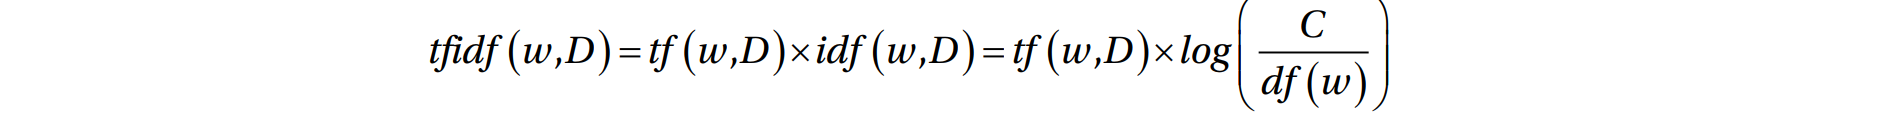
    
This weight is a statistical used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.
    
#### Term frequency
$$TF_{word,document} = \frac{\#\_of\_times\_word\_appears\_in\_document}{total\_\#\_of\_words\_in\_document}$$

TF measures **how frequently a term occurs in a document**. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization
    
#### Document frequency
$$ DF_{word} = \frac{\#\_of\_documents\_containing\_word}{total\_\#\_of\_documents} $$
    
#### Inverse document frequency
$$ IDF_{word} = \log\left(\frac{total\_\#\_of\_documents}{\#\_of\_documents\_containing\_word}\right) $$
    
The term idf(w, D) is the inverse **document frequency for the term w**, which can be computed as the log transform of the total number of documents in the corpus C divided by the document frequency of the word w, which is basically the frequency of documents in the corpus where the word w occurs. 

idf measrues how important a term is. While computing tf, all terms are considered equally important. However, it is known that certain terms, such as "is", "beautiful" may appear a lot of times but have little importance. Thus, we need to weight down the frequent terms while scale up the rare ones, by computing the idf 
 


#### Example

Vocabulary:
```
['drop', 'help', 'jeff', 'octopus', 'police', 'said', 'sandwich', 'sandwichlessly', 'sobbed', 'stole']
```

TF: 
```
['jeff', 'stole', 'octopus', 'sandwich']
[0, 0, 1/4, 1/4, 0, 0, 1/4, 0, 0, 1/4]

['help', 'sobbed', 'sandwichlessly']
[0, 1/3, 0, 0, 0, 0, 0, 1/3, 1/3, 0]

['drop', u'sandwich', 'said', 'sandwich', 'police']
[1/5, 0, 0, 0, 1/5, 1/5, 2/5, 0, 0, 0]
```


DF for each word:
```
[1/3, 1/3, 1/3, 1/3, 1/3, 1/3, 2/3, 1/3, 1/3, 1/3]
```

IDF for each word:
```
[1.099, 1.099, 1.099, 1.099, 1.099, 1.099, 0.405, 1.099, 1.099, 1.099]
```

TFIDF = TF * IDF:
```
['jeff', 'stole', 'octopus', 'sandwich']
[0, 0, 0.275, 0.275, 0, 0, 0.101, 0, 0, 0.275]

['help', 'sobbed', 'sandwichlessly']
[0, 0.366, 0, 0, 0, 0, 0, 0.366, 0.366, 0]

['drop', u'sandwich', 'said', 'sandwich', 'police']
[0.22, 0, 0, 0, 0.22, 0.22, 0.162, 0, 0, 0]
```

In [15]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), lowercase=False)

### <font color='blue'>**Problem with Bag of words model**
    
1. It is simple to make, but it less accurate because it does not take the word order or grammar into account.
2.  it creates parse matrix which means there are so many features but most of the are zero for each text input

In [16]:
'''
Vectorize corpus with Bag-of-Words (classic Count or Tf-Idf variant), plots the most frequent words.
:parameter
    :param corpus: list - dtf["text"]
    :param vectorizer: sklearn vectorizer object, like Count or Tf-Idf
    :param vocabulary: list of words or dict, if None it creates from scratch, else it searches the words into corpus
:return
    sparse matrix, list of text tokenized, vectorizer, dic_vocabulary, X_names
'''
def fit_bow(corpus, vectorizer=None, vocabulary=None):
    ## vectorizer
    vectorizer = feature_extraction.text.TfidfVectorizer(max_features=None, ngram_range=(1,1), vocabulary=vocabulary) if vectorizer is None else vectorizer
    vectorizer.fit(corpus)
    
    ## sparse matrix
    print("--- creating sparse matrix ---")
    X = vectorizer.transform(corpus)
    print("shape:", X.shape)
    
    ## vocabulary
    print("--- creating vocabulary ---") if vocabulary is None else print("--- used vocabulary ---")
    dic_vocabulary = vectorizer.vocabulary_   #{word:idx for idx, word in enumerate(vectorizer.get_feature_names())}
    print(len(dic_vocabulary), "words")
    
    ## text2tokens
    print("--- tokenization ---")
    tokenizer = vectorizer.build_tokenizer()
    preprocessor = vectorizer.build_preprocessor()
    lst_text2tokens = []
    for text in corpus:
        lst_tokens = [dic_vocabulary[word] for word in tokenizer(preprocessor(text)) if word in dic_vocabulary]
        lst_text2tokens.append(lst_tokens)
    print(len(lst_text2tokens), "texts")
    
    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X.todense()[:,np.random.randint(0,X.shape[1],100)]==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sparse Matrix Sample')
    plt.show()
    return {"X":X, "lst_text2tokens":lst_text2tokens, "vectorizer":vectorizer, "dic_vocabulary":dic_vocabulary, "X_names":vectorizer.get_feature_names()}

--- creating sparse matrix ---
shape: (7259, 12296)
--- creating vocabulary ---
12296 words
--- tokenization ---
7259 texts


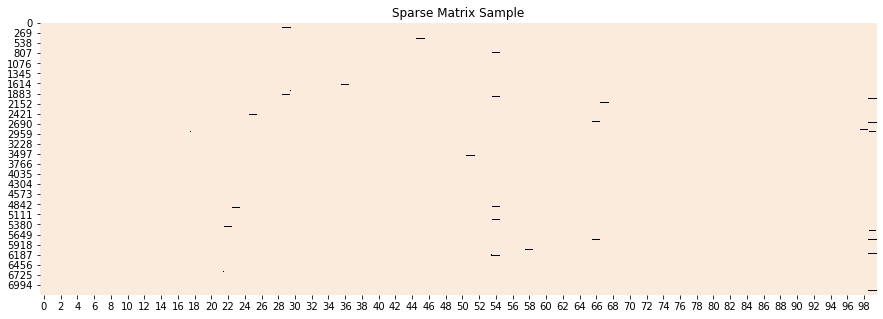

In [17]:
dic_bow = fit_bow(corpus=df_train["text_clean"], vectorizer=vectorizer, vocabulary=None)
X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [18]:
# check some features
f_range = (500, 505)

print("fetures name (from dic_vocabulary):")
print({k:v for k,v in sorted(dic_vocabulary.items(), key=lambda item:item[1], reverse=False)
      if v in np.arange(f_range[0], f_range[1]+1, step=1)})

print("")
print("value of these features (in the sparse matrix) for the first text:")
print(vectorizer.get_feature_names()[f_range[0]:f_range[1]])
print(X_train[0, f_range[0]:f_range[1]].todense())

fetures name (from dic_vocabulary):
{'arch': 500, 'archaic': 501, 'archeri': 502, 'archi': 503, 'archibald': 504, 'architect': 505}

value of these features (in the sparse matrix) for the first text:
['arch', 'archaic', 'archeri', 'archi', 'archibald']
[[0. 0. 0. 0. 0.]]


In [19]:
# check text conversion
i = 0

## list of text: ["I like this", ...]
len_txt = len(df_train["text_clean"].iloc[i].split())
print("from: ", df_train["text_clean"].iloc[i], "| len:", len_txt)

## list of token ids: [[1, 2, 3], ...]
len_tokens = len(lst_text2tokens[i])
print("to: ", lst_text2tokens[i], "| len:", len(lst_text2tokens[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", df_train["text_clean"].iloc[i].split()[0], " -- idx in vocabulary -->", 
      dic_vocabulary[df_train["text_clean"].iloc[i].split()[0]])

## words not in vocabulary?
if len_txt-len_tokens != 0:
    missing_words = [word for word in df_train["text_clean"].iloc[i].split() if word not in dic_vocabulary.keys()]
    print("!!!", len_txt-len_tokens, "words not in vocabulary:", missing_words)

from:  jet chairman christoph johnson wont fine player anthem protest never want put restrict speech player | len: 15
to:  [5711, 1725, 1860, 5746, 12096, 3921, 8284, 401, 8597, 7375, 11848, 8671, 9085, 10222, 8284] | len: 15
check:  jet  -- idx in vocabulary --> 5711


 ## <font color=red>**5.2. Feature Selection**

In [20]:

'''
Perform feature selection using p-values (keep highly correlated features)
:parameter
    :param X: array - like sparse matrix or dtf.values
    :param y: array or dtf - like dtf["y"]
    :param X_names: list - like vetcorizer.get_feature_names()
    :param top: int - ex. 1000 takes the top 1000 features per classes of y. If None takes all those with p-value < 5%.
    :param print_top: int - print top features
:return
    dtf with features and scores
'''
def features_selection(X, y, X_names, top=None, print_top=10):    
    ## selection
    dtf_features = pd.DataFrame()
    for cat in np.unique(y):
        chi2, p = feature_selection.chi2(X, y==cat)
        dtf_features = dtf_features.append(pd.DataFrame({"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>0.95] #p-value filter
    if top is not None:
        dtf_features = dtf_features.groupby('y')["y","feature","score"].head(top)
    
    ## print
    print("features selection: from", "{:,.0f}".format(len(X_names)), 
          "to", "{:,.0f}".format(len(dtf_features["feature"].unique())))
    print(" ")
    for cat in np.unique(y):
        print("# {}:".format(cat))
        print("  . selected features:", len(dtf_features[dtf_features["y"]==cat]))
        print("  . top features:", ", ".join(dtf_features[dtf_features["y"]==cat]["feature"].values[:print_top]))
        print(" ")
    return dtf_features["feature"].unique().tolist(), dtf_features

In [21]:
X_names, df_selection = features_selection(X_train, df_train["y"], X_names, top=None, print_top=10)

features selection: from 12,296 to 484
 
# BUSINESS:
  . selected features: 484
  . top features: busi, nfl, olymp, compani, player, footbal, game, market, nba, job
 
# SPORTS:
  . selected features: 484
  . top features: busi, nfl, olymp, compani, player, footbal, game, market, nba, job
 


In [22]:
df_selection.sample(5)

,feature,score,y
11219,treatment,0.954,BUSINESS
7325,ncaa,1.000,BUSINESS
7056,mlb,0.999,SPORTS
9093,retail,0.999,BUSINESS
10853,tebow,0.980,BUSINESS


--- creating sparse matrix ---
shape: (7259, 484)
--- used vocabulary ---
484 words
--- tokenization ---
7259 texts


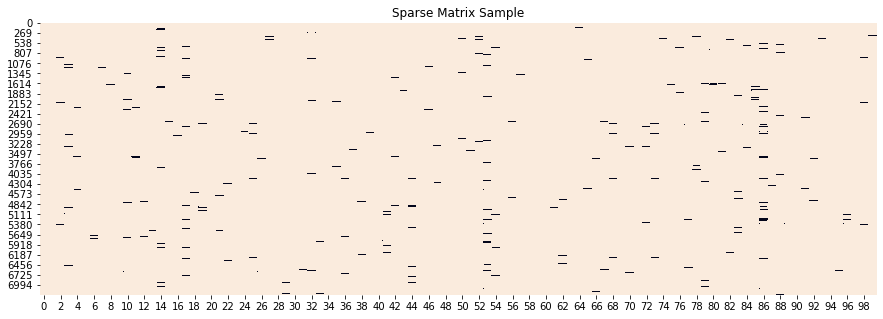

In [23]:
# Recreate Vectorizer with the selected vocabulary
dic_bow = fit_bow(corpus=df_train["text_clean"], vocabulary=X_names)

X_train, X_names, vectorizer, dic_vocabulary, lst_text2tokens = dic_bow["X"], dic_bow["X_names"], dic_bow["vectorizer"], dic_bow["dic_vocabulary"], dic_bow["lst_text2tokens"]

In [24]:
'''
Transform a sparse matrix into a dtf with selected features only.
:parameter
    :param X: array - like sparse matrix or dtf.values
    :param dic_vocabulary: dict - {"word":idx}
    :param X_names: list of words - like vetcorizer.get_feature_names()
    :param prefix: str - ex. "x_" -> x_word1, x_word2, ..
'''
def sparse2dtf(X, dic_vocabulary, X_names, prefix=""):
    dtf_X = pd.DataFrame()
    for word in X_names:
        idx = dic_vocabulary[word]
        dtf_X[prefix+word] = np.reshape(X[:,idx].toarray(), newshape=(-1))
    return dtf_X

In [25]:
# Explore the sparse matrix as dtf
df_X_train = sparse2dtf(X_train, dic_vocabulary, X_names, prefix="")
df_X_train = pd.concat([df_train[["text","y"]], df_X_train.set_index(df_train.index)], axis=1)
print(df_X_train.shape)

(7259, 486)


 ## <font color=red>**5.3. Naive Bayes Classfication**

In [26]:
#X_train = df_test["text_clean"]
X_test = df_test["text_clean"]

classifier = naive_bayes.MultinomialNB()

## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [27]:
'''
Fits a sklearn classification model.
:parameter
    :param X_train: feature matrix
    :param y_train: array of classes
    :param X_test: raw text
    :param vectorizer: vectorizer object - if None Tf-Idf is used
    :param classifier: model object - if None MultinomialNB is used
:return
    fitted model and predictions
'''
def fit_ml_classif(X_train, y_train, X_test, vectorizer=None, classifier=None): 
    ## model pipeline
    vectorizer = feature_extraction.text.TfidfVectorizer() if vectorizer is None else vectorizer
    classifier = naive_bayes.MultinomialNB() if classifier is None else classifier
    model = pipeline.Pipeline([("vectorizer",vectorizer), ("classifier",classifier)])
    
    ## train
    if vectorizer is None:
        model.fit(X_train, y_train)
    else:
        model["classifier"].fit(X_train, y_train)
    
    ## test
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    return model, predicted_prob, predicted


In [28]:
model, predicted_prob, predicted = fit_ml_classif(X_train, y_train, X_test, vectorizer, classifier)

In [29]:
from sklearn import metrics
accuracy = metrics.accuracy_score(y_test, predicted)
accuracy

0.9113110539845758

In [30]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
auc = metrics.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
auc

0.9730366613236063

 ## <font color=red>**Evaluate**

In [39]:
from sklearn import metrics

def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
        
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test_array, predicted_prob)
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))


    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()

In [32]:
y_test

0       BUSINESS
1       BUSINESS
2         SPORTS
3         SPORTS
4       BUSINESS
          ...   
3107    BUSINESS
3108      SPORTS
3109      SPORTS
3110      SPORTS
3111      SPORTS
Name: y, Length: 3112, dtype: object

In [33]:
predicted

array(['BUSINESS', 'BUSINESS', 'SPORTS', ..., 'SPORTS', 'SPORTS',
       'SPORTS'], dtype='<U8')

Accuracy: 0.91
Auc: 0.97
Detail:
              precision    recall  f1-score   support

    BUSINESS       0.98      0.89      0.93      2106
      SPORTS       0.80      0.96      0.87      1006

    accuracy                           0.91      3112
   macro avg       0.89      0.92      0.90      3112
weighted avg       0.92      0.91      0.91      3112



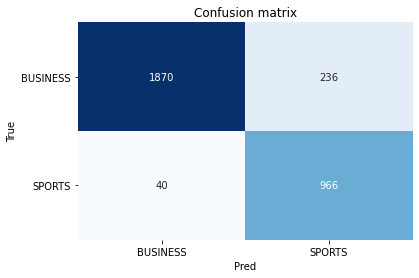

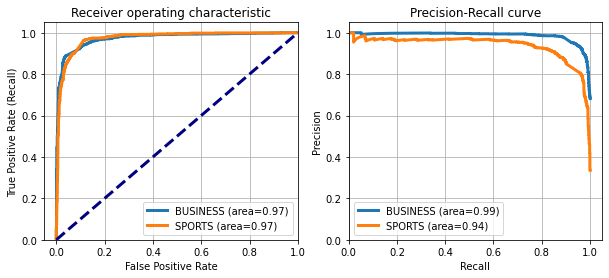

In [34]:
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))

 ## <font color=red>**Explainability**

In [35]:
'''
Use lime to build an a explainer.
:parameter
    :param model: pipeline with vectorizer and classifier
    :param Y_train: array
    :param txt_instance: string - raw text
    :param top: num - top features to display
:return
    dtf with explanations
'''
def explainer_lime(model, y_train, txt_instance, top=10):
    explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
    explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=top) 
    explained.show_in_notebook(text=txt_instance, predict_proba=False)
    dtf_explainer = pd.DataFrame(explained.as_list(), columns=['feature','effect'])
    return dtf_explainer

i = 9
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
print(" ")
exp = explainer_lime(model, y_train, txt_instance=df_test["text"].iloc[i], top=3)

True: SPORTS --> Pred: SPORTS | Prob: 0.98
 


---
# <div class="alert alert-info">**6. Approach 2: Word2Vec using Gensim framework + DNN)**
    
1. **Step 1 - Feature Engineering**: In this approach, feature engineering technique is based on word embeddings technique to capture contextual and semantic information.
2. **Step 2 - Machine Learning model**: Apply DNN to classify text

 ## <font color=red>**6.1. Feature Engineering**

1. Basically, a word embedding not only converts the word but also identifies the semantics and syntaxes of the world to build a vector representation of this information. The underlying concept is to use information from the words adjacent to the word.  
2. For example, the word for “lion” will be closer in value to “cat” than to “dandelion”
    
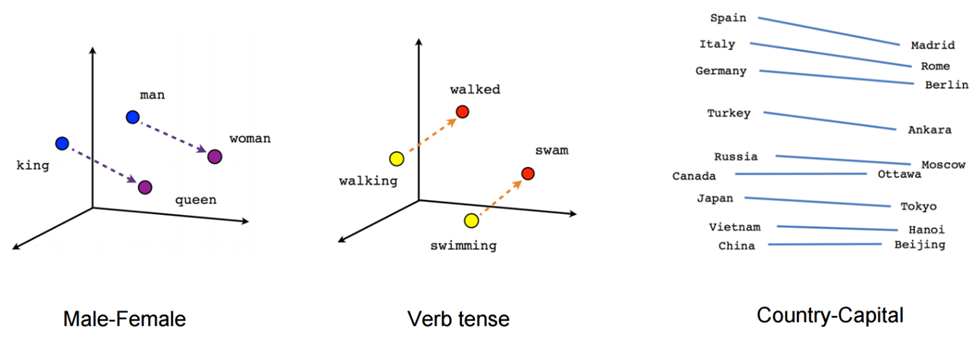
    
3. Some popular word embedding techniques include Word2Vec, GloVe, ELMo, FastText, etc    

### <font color='blue'>**Word Tokenizer**

In [25]:
wpt = nltk.WordPunctTokenizer()
train_corpus = [wpt.tokenize(document) for document in df_train['text_clean']]
test_corpus = [wpt.tokenize(document) for document in df_test['text_clean']]

### <font color='blue'>**Word embedding using Gensim Framework - word2vec**
    
The word2vec model in gensim framework was released by Google in 2013 and uses a neural network based implementation with architectures like continuous Bag of Words and Skip-Grams to learn the distributed vector representation of words in a corpus

    
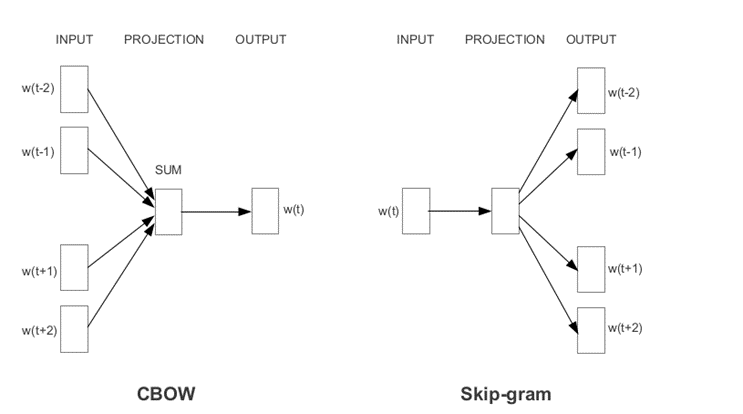

We will be using genism framework to implement the same model on our corpus to extract features. Some of the important parameters in the model are explained briefly as follows
+ Size: Represents the feature vector size for each word in the corpus when transformed
+ Window: Sets the context window size specifying the length of the window of words to be taken into account as belonging to a single, similar context when training
+ Min_count: Specifies the minimum word frequency value needed across the corpus to consider the word as a part of the final vocabulary during training the model
+ Sample: Used to downsample the effects of words which occur very frequently


In [26]:
from gensim.models import word2vec
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'

# Set values for various parameters
feature_size = 300    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(size=feature_size, 
                              window=window_context, 
                              min_count = min_word_count,
                              sample=sample)
w2v_model.build_vocab(train_corpus)
w2v_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)
w2v_model.train(train_corpus, total_examples=w2v_model.corpus_count, epochs=5)

(572513, 583945)

In [27]:
w2v_model.wv.similarity("travel","cat"), w2v_model.wv.similarity("dog","cat")


(0.246192, 0.76346207)

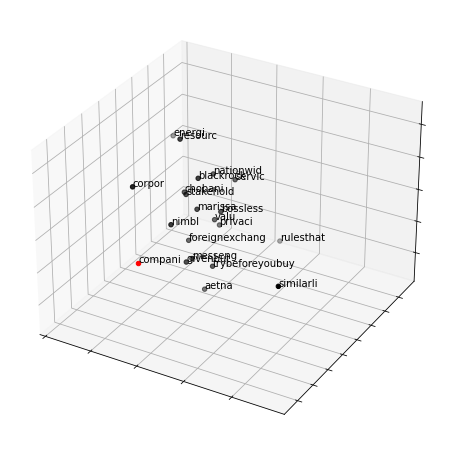

In [28]:
word = "compani"
fig = plt.figure(figsize=(12,8))
## word embedding
tot_words = [word] + [tupla[0] for tupla in w2v_model.most_similar(word, topn=20)]
X = w2v_model[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D

ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[],  yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

### <font color='blue'>**Create feature vector for each document**
    
In order to represent features of entire documents, we can do that using various aggregation and combinations. A simple scheme would be to use an averaged word vector representation, where we simply sum all the word vectors occurring in a document and then divide by the count of word vectors to represent an averaged word vector for the document

In [29]:
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype='float64')
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1
            feature_vector = np.add(feature_vector, model[word])
            
    if words:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def  averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    #vocabulary = list(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model.wv, vocabulary, num_features) for tokenized_sentence in corpus]
  
    return features

In [30]:
w2v_train_feature_array = averaged_word_vectorizer(corpus=train_corpus, model=w2v_model,num_features=feature_size)
w2v_test_feature_array = averaged_word_vectorizer(corpus=test_corpus, model=w2v_model,num_features=feature_size)
X_train = pd.DataFrame(w2v_train_feature_array)
X_test = pd.DataFrame(w2v_test_feature_array)

X_train.shape

(7250, 300)

In [31]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.087,0.233,0.380,0.355,0.017,-0.195,0.223,-0.453,0.533,0.190,-0.183,-0.744,-0.242,0.076,-0.291,0.450,0.236,0.444,0.055,-0.529,0.029,0.301,0.351,-0.218,-0.079,-0.293,-0.509,0.183,0.184,0.001,0.100,0.299,-0.249,-0.237,0.010,0.090,0.277,0.279,0.202,0.512,0.191,-0.501,0.651,0.016,-0.041,-0.276,-0.032,-0.298,-0.067,0.323,-0.239,0.204,0.204,-0.009,0.142,-0.302,-0.342,-0.229,-0.086,-0.455,-0.196,0.203,-0.216,-0.159,-0.034,-0.135,-0.311,0.247,0.098,0.506,0.349,0.308,-0.024,0.072,-0.765,-0.250,0.299,0.083,0.235,-0.080,-0.032,0.035,0.043,-0.098,0.278,-0.106,-0.432,0.566,0.189,0.072,0.144,0.022,-0.415,-0.297,-0.126,-0.175,0.327,0.276,0.240,-0.223,-0.260,0.198,0.413,-0.058,-0.089,0.017,0.074,-0.245,0.087,-0.204,-0.334,-0.128,-0.212,-0.045,0.342,-0.071,0.179,-0.077,0.118,0.058,-0.120,0.005,-0.313,0.076,0.116,-0.673,-0.325,-0.176,0.053,-0.156,-0.165,-0.528,-0.150,0.020,-0.103,-0.173,-0.280,0.398,-0.157,0.166,0.311,-0.313,0.150,0.003,-0.123,0.306,-0.006,-0.220,-0.134,-0.414,0.615,0.156,-0.462,0.035,-0.155,-0.251,-0.024,-0.319,-0.054,-0.263,0.032,0.270,0.462,-0.078,-0.069,-0.683,0.477,-0.461,-0.106,0.138,-0.405,-0.092,0.047,-0.325,-0.129,-0.059,0.526,-0.312,-0.017,-0.092,-0.016,-0.076,0.249,0.143,-0.181,0.184,-0.161,0.010,0.279,0.136,0.306,0.271,0.050,0.226,0.153,0.101,-0.142,0.061,-0.291,-0.249,-0.284,0.090,-0.116,-0.252,0.092,-0.400,0.195,-0.139,-0.023,-0.131,0.044,0.373,-0.083,-0.059,-0.583,0.049,0.193,-0.225,-0.675,-0.265,-0.257,-0.272,0.083,-0.026,0.522,-0.057,0.416,0.212,0.147,-0.219,0.225,-0.103,-0.199,0.033,0.245,0.084,0.088,-0.422,0.352,-0.078,0.335,-0.177,0.126,-0.442,-0.227,0.304,-0.396,0.208,0.050,-0.180,0.355,0.273,0.233,0.139,0.328,-0.178,-0.094,0.225,-0.072,-0.146,0.066,0.165,0.040,0.062,0.113,0.430,-0.297,0.182,-0.334,-0.102,-0.041,0.321,0.167,0.097,0.080,-0.343,-0.273,-0.427,-0.522,0.102,0.057,0.047,0.292,0.451,-0.234,-0.115,-0.382,0.191,0.263,0.128,0.174,0.127,-0.330,-0.085,-0.069,-0.167,-0.200,-0.431,-0.085,0.112
1,-0.124,0.293,0.074,0.335,-0.305,-0.172,0.130,-0.422,0.409,0.384,-0.207,-0.376,-0.300,0.072,-0.564,0.466,0.188,0.380,0.041,-0.363,-0.029,0.132,0.327,-0.113,0.082,0.130,-0.490,0.217,0.105,-0.021,-0.123,-0.080,-0.227,-0.191,-0.143,-0.099,0.008,0.145,0.265,0.326,0.261,-0.237,0.592,0.098,-0.289,-0.447,-0.072,0.044,-0.335,0.292,0.100,0.218,-0.003,0.066,0.003,0.056,-0.511,-0.362,0.075,-0.432,-0.183,0.114,-0.568,-0.114,-0.128,-0.333,-0.352,0.313,-0.052,0.298,0.035,0.134,0.467,0.009,-0.562,-0.247,0.255,0.451,0.071,0.039,-0.001,-0.192,-0.020,-0.011,0.069,0.017,-0.463,0.469,-0.090,0.221,0.328,-0.109,-0.267,-0.311,-0.031,-0.264,0.151,-0.026,0.518,-0.085,-0.128,-0.151,0.068,0.066,0.029,-0.228,-0.183,-0.195,0.246,-0.163,-0.244,-0.288,-0.246,-0.017,0.377,0.203,0.058,-0.228,0.356,0.204,0.031,0.051,-0.396,0.306,0.253,-0.223,-0.121,-0.252,0.120,0.142,-0.144,-0.238,-0.083,-0.150,-0.092,-0.001,-0.138,-0.001,-0.108,0.191,0.358,-0.513,-0.061,0.176,0.107,-0.126,-

 ## <font color=red>**DNN architecture**

In [32]:
# Deep Learning libraries
import tensorflow as tf
import keras

def construct_deepnn_architecture(num_input_features):
    
    tf.random.set_seed(42)
    np.random.seed(42)
    keras.backend.clear_session()

    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(500, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(500, activation='relu'))
    dnn_model.add(Dropout(0.2))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return dnn_model

In [33]:
w2v_dnn = construct_deepnn_architecture(num_input_features=300)

y_tr = pd.get_dummies(df_train['y'], drop_first=False).values
y_val = pd.get_dummies(df_test['y'], drop_first=False).values

In [34]:
batch_size = 20
w2v_dnn.fit(X_train, np.array(y_tr), epochs=20, batch_size=batch_size, shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/20
327/327 [==============================] - 3s 7ms/step - loss: 0.2082 - accuracy: 0.9166 - val_loss: 0.1898 - val_accuracy: 0.9352
Epoch 2/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1777 - accuracy: 0.9341 - val_loss: 0.1819 - val_accuracy: 0.9352
Epoch 3/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1713 - accuracy: 0.9338 - val_loss: 0.1838 - val_accuracy: 0.9352
Epoch 4/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1690 - accuracy: 0.9361 - val_loss: 0.1998 - val_accuracy: 0.9324
Epoch 5/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1614 - accuracy: 0.9402 - val_loss: 0.2086 - val_accuracy: 0.9228
Epoch 6/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1608 - accuracy: 0.9398 - val_loss: 0.1783 - val_accuracy: 0.9338
Epoch 7/20
327/327 [==============================] - 2s 6ms/step - loss: 0.1533 - accuracy: 0.9421 - val_loss: 0.1962 - val_accuracy: 0.9241
Epoch 

In [35]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_val))}

## test
predicted_prob = w2v_dnn.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
predicted = np.array(predicted)
predicted

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

In [36]:
y_test

0       BUSINESS
1       BUSINESS
2       BUSINESS
3       BUSINESS
4       BUSINESS
          ...   
3103    BUSINESS
3104    BUSINESS
3105      SPORTS
3106      SPORTS
3107      SPORTS
Name: y, Length: 3108, dtype: object

In [37]:
y_tr = pd.get_dummies(df_train['y'], drop_first=False).values
y_val = pd.get_dummies(df_test['y'], drop_first=False).values

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      2102
           1       0.80      0.97      0.87      1006

    accuracy                           0.91      3108
   macro avg       0.89      0.92      0.90      3108
weighted avg       0.92      0.91      0.91      3108



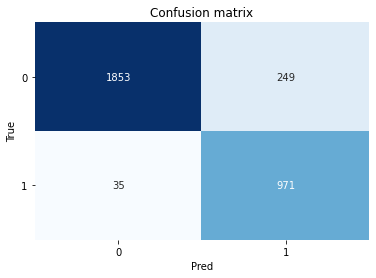

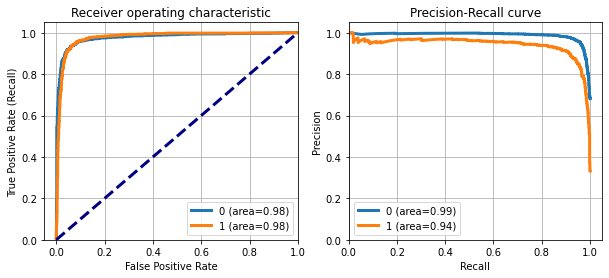

In [40]:
from sklearn import metrics
y_test = pd.get_dummies(df_test['y'], drop_first=True).values.ravel()
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))

---
# <div class="alert alert-info">**9. Approach 3: LSTM**

## <font color=red>**Introduction**
    
Another interesting approach toward supervised Deep Learning is the use of RNN and LSTM which also consider the sequence data (words, events and so on). These are more advanced models  than regular fully connected deep networks and usually take more time to train. 

## <font color=red>**Feature Engineering**
    
With this approach, we will be creating word embeddings ourselves instead of using pre-built ones like word2vec or Glove, which were used in the previous approach.  
       
The flollowing steps are applied to transform text to number:



### <font color=blue>**Convert text to numeric data using word embedding from LSTM**

#### Tokenize word

For generating embeddings, first we will use the Embedding layer from keras to convert text into numeric representations

In [41]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the sentences
# tokenizer = Tokenizer()
tokenizer = Tokenizer(lower=True, split=' ',
                      oov_token="NaN",
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# Preparing vocabulary
tokenizer.fit_on_texts(list(df_train['text_clean']))

# show words and token ids
dic_vocabulary = tokenizer.word_index
dic_vocabulary.items()

dict_items([('NaN', 1), ('busi', 2), ('new', 3), ('woman', 4), ('u', 5), ('make', 6), ('year', 7), ('compani', 8), ('one', 9), ('get', 10), ('say', 11), ('time', 12), ('game', 13), ('world', 14), ('team', 15), ('like', 16), ('player', 17), ('olymp', 18), ('nfl', 19), ('peopl', 20), ('work', 21), ('way', 22), ('first', 23), ('win', 24), ('go', 25), ('need', 26), ('market', 27), ('take', 28), ('want', 29), ('chang', 30), ('day', 31), ('sport', 32), ('footbal', 33), ('thing', 34), ('job', 35), ('dont', 36), ('look', 37), ('state', 38), ('could', 39), ('said', 40), ('use', 41), ('fan', 42), ('ceo', 43), ('trump', 44), ('think', 45), ('come', 46), ('help', 47), ('nba', 48), ('right', 49), ('call', 50), ('know', 51), ('best', 52), ('success', 53), ('play', 54), ('back', 55), ('even', 56), ('still', 57), ('american', 58), ('mani', 59), ('good', 60), ('two', 61), ('athlet', 62), ('pay', 63), ('employe', 64), ('big', 65), ('coach', 66), ('start', 67), ('may', 68), ('leader', 69), ('show', 70), 

In [42]:
print("Vocabulary: ", dict(list(dic_vocabulary.items())[0:5]))
len(dic_vocabulary.items()), len(dic_vocabulary)

Vocabulary:  {'NaN': 1, 'busi': 2, 'new': 3, 'woman': 4, 'u': 5}


(12285, 12285)

In [43]:
VOCAB_SIZE = len(tokenizer.word_index) + 1  # +1 for padding
print(VOCAB_SIZE)

12286


#### Convert text into integer sequences 

Create a word to index vocabulary maping for representing each tokenized text in each document in a numeric form. We would also need to create a numeric mapping for the padding term which we shall call PAD_INDEX and assign it the numeric index of 0. For unknown terms, in case they are encountered later on the test dataset or newer, previously unseen, we would need to assign it to some index too. This would be because we will vectorize, engineer features, and build models only on the training data. Hence, if some new term should come up in the future (which was originally not a part of the model training), we will consider it as an out of vocabulary (OOV) term and assign it to a constant index. We will name this term NOT_FOUND_INDEX and assign it the index of vocab_size + 1 

In [44]:
# conver text into integer sequences
x_tr_seq = tokenizer.texts_to_sequences(df_train['text_clean'])
x_val_seq = tokenizer.texts_to_sequences(df_test['text_clean'])

In [45]:
i = 0

## print words/tokens in a document
len_txt  = len(df_train["text_clean"].iloc[i].split())
print("from: ", df_train["text_clean"].iloc[i], "| len:", len_txt)

## sequence of token id
len_tokens = len(x_tr_seq[i])
print("to: ", x_tr_seq[i], "| len:", len(x_tr_seq[i]))

# compare with vocabulary
for j in range(0, len(df_train["text_clean"].iloc[i].split())):
    print("check: ", j, df_train["text_clean"].iloc[i].split()[j],
      " -- idx in vocabulary -->",
      dic_vocabulary[df_train["text_clean"].iloc[i].split()[j]])
    


from:  jet chairman christoph johnson wont fine player anthem protest never want put restrict speech player | len: 15
to:  [1275, 1711, 5082, 649, 183, 447, 17, 448, 321, 141, 29, 116, 2365, 1276, 17] | len: 15
check:  0 jet  -- idx in vocabulary --> 1275
check:  1 chairman  -- idx in vocabulary --> 1711
check:  2 christoph  -- idx in vocabulary --> 5082
check:  3 johnson  -- idx in vocabulary --> 649
check:  4 wont  -- idx in vocabulary --> 183
check:  5 fine  -- idx in vocabulary --> 447
check:  6 player  -- idx in vocabulary --> 17
check:  7 anthem  -- idx in vocabulary --> 448
check:  8 protest  -- idx in vocabulary --> 321
check:  9 never  -- idx in vocabulary --> 141
check:  10 want  -- idx in vocabulary --> 29
check:  11 put  -- idx in vocabulary --> 116
check:  12 restrict  -- idx in vocabulary --> 2365
check:  13 speech  -- idx in vocabulary --> 1276
check:  14 player  -- idx in vocabulary --> 17


**Padding to prepare sequences of same length**:Next, we would also need the vectors to be of uniform size even though the tokenized text will be of variable length due to the difference number of tokens in each document. For this, one strategy could be to take the length of longest headline (which maximum number of tokens/words) and set it as the vector size, called max_len. Headlines of shorter length can be padded with a PAD term in the beginning to increase their length to max_len. This transform the corpus into padded sequences of word ids to get a feature matrix.  
+ THen, create an embedding matrix so that the vector of the word with id N is located at the Nth row
+ Finally, build a neural network with an embedding layer thay weights every word in the sentences with the corresponding vector

In [46]:
# padding to prepare sequences at the same length
x_tr_seq = pad_sequences(x_tr_seq, maxlen=20)
x_val_seq = pad_sequences(x_val_seq, maxlen=20)

print(x_tr_seq.shape)
x_tr_seq

(7250, 20)


array([[    0,     0,     0, ...,  2365,  1276,    17],
       [  650,  1530,   129, ...,  2837,  6951,   708],
       [    0,     0,     0, ...,  3600,     5,   149],
       ...,
       [ 2756,  3832,  6950, ...,  1371,   479,   596],
       [ 1913, 12280, 12281, ...,  1201, 12283, 12284],
       [    0,     0,     0, ...,   870,  2013,  3570]])

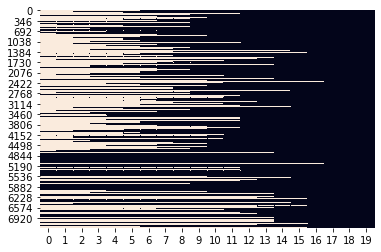

In [47]:
sns.heatmap(x_tr_seq==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [48]:
x_tr_seq.shape, x_val_seq.shape

((7250, 20), (3108, 20))

### <font color=blue>**Convert target from text to numeric data**

In [49]:
y_tr = pd.get_dummies(df_train['y'], drop_first=False).values
y_val = pd.get_dummies(df_test['y'], drop_first=False).values

## <font color=red>**LSTM Model - Define architecture**
    
### <font color=blue>Creating embedding layer output for each document/text

We can now proceed training classification model by introducing the Embedding layer and couple it with LSTMS, described as the following section    
    
2. The Embedding layer helps to generate the word embeddings from scratch. This layer is initialized with some weights gets updated based on optimizer when the network tries to minimize the loss. Thus the embedding layer tries to optimie its weights such that we get the best word embeddings which will generate minimum error in the model and also capture semantic similarity and relations among words. The word embeddings would be generated somewhat similar to figure  <br>
    
    
3. The model architecture:
    + The Embedding layer takes in three parameters - input dim, which is equal to the vocabulary size (VOCAB_SIZE), output_dim which is VOCAB_MAP, representing the dimension of dense embedding vector, and INPUT_LEN, which specifies the length of the input sequences (sequence vectors)
    + These dense word embeddings are then passed to the LSTM layer having 64 units. <br>
    
    
4. Example: In the example depicted in Figure 7-10
    + Suppose there is one review, the dimesion is (1,3). This review is converted into a numeric sequence [2, 57, 121] based on the vocabulary mapping. 
    + Then the specific columns representing the indices in the review sequence are selected from the EMBEDDING_LAYER (vectors at column indices 2, 57, 121 respectively), to generate the final word embeddings. This gives us an embedding vector of dimension (1, 128, 3) also represented as (1,3,128) when each row is represented based on sequence word embedding vector 
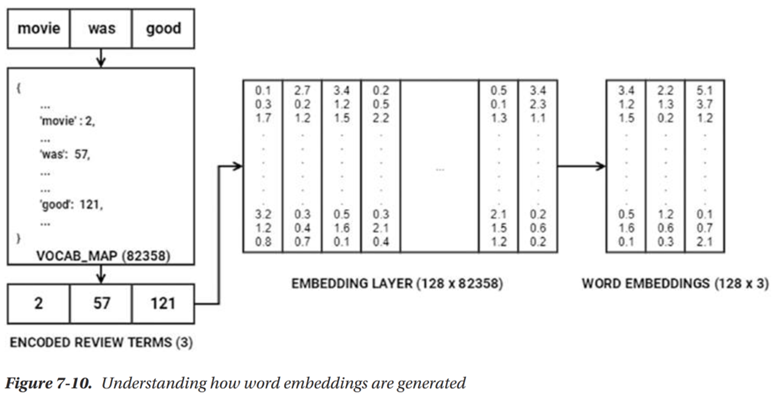
    


#### 1. Creating embedding layer output for each document/text

4. Example: In the example depicted in Figure 7-10
    + Suppose there is one review, the dimesion is (1,3). This review is converted into a numeric sequence [2, 57, 121] based on the vocabulary mapping. 
    + Then the specific columns representing the indices in the review sequence are selected from the EMBEDDING_LAYER (vectors at column indices 2, 57, 121 respectively), to generate the final word embeddings. This gives us an embedding vector of dimension (1, 128, 3) also represented as (1,3,128) when each row is represented based on sequence word embedding vector 

An Embedding layer that takes the sequences as input and the word vectors as weights, described as the following section.

First, creating the embedding matrix in the first Embedding layer of the neural network that will be built and trained to classify the news. Each id in the input sequence will be used as the index to access the embedding matrix. The output of this Embedding layer will be a 2D matrix with a word vector for each word id in the input sequence (Sequence length x Vector size). Let’s use the sentence “I like this article” as an example:

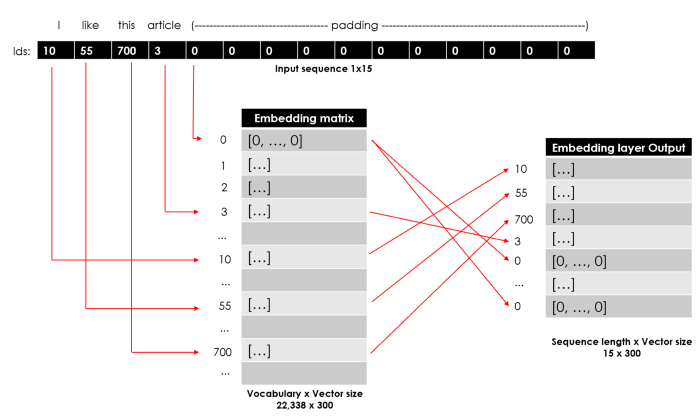

### <font color=blue>Setup

In [66]:
# deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *

tf.random.set_seed(42)
np.random.seed(42)
backend.clear_session()
tf.keras.backend.clear_session()

In [68]:
VOCAB_SIZE = len(tokenizer.word_index) + 1   # +1 for padding
VOCA_MAP = 300
INPUT_LEN = 20

model = Sequential()

# embedding layer
model.add(Embedding(VOCAB_SIZE, VOCAB_MAP, input_length=INPUT_LEN, trainable=True))

# lstm layer
model.add(LSTM(128, return_sequences=True, dropout=0.2))

# Global Maxpooling
model.add(GlobalMaxPool1D())

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])

# Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('classification_lstm.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

# Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           3685800   
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           219648    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 3,913,834
Trainable params: 3,913,834
Non-trainable params: 0
____________________________________________

The total number of trainable parameters in this model is 3,919,234. **That's huge**

In [69]:
history = model.fit(np.array(x_tr_seq), np.array(y_tr), batch_size=128, epochs=10, validation_data=(np.array(x_val_seq), np.array(y_val)), verbose=1, callbacks=[es,mc])

Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.4584 - acc: 0.7746
Epoch 00001: val_acc improved from -inf to 0.91216, saving model to classification_lstm.h5
57/57 [==============================] - 8s 97ms/step - loss: 0.4584 - acc: 0.7746 - val_loss: 0.2131 - val_acc: 0.9122
Epoch 2/10
57/57 [==============================] - ETA: 0s - loss: 0.0797 - acc: 0.9737
Epoch 00002: val_acc improved from 0.91216 to 0.92535, saving model to classification_lstm.h5
57/57 [==============================] - 5s 80ms/step - loss: 0.0797 - acc: 0.9737 - val_loss: 0.1948 - val_acc: 0.9254
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.0212 - acc: 0.9956
Epoch 00003: val_acc did not improve from 0.92535
57/57 [==============================] - 4s 78ms/step - loss: 0.0212 - acc: 0.9956 - val_loss: 0.2727 - val_acc: 0.9205
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.0061 - acc: 0.9985
Epoch 00004: val_acc did not improve from 0.92535

In [70]:
# loading best model
from keras.models import load_model
model = load_model('classification_lstm.h5')

# evaluation
_, val_acc = model.evaluate(x_val_seq, y_val, batch_size=128)
print(val_acc)

25/25 [==============================] - 1s 17ms/step - loss: 0.1948 - acc: 0.9254
0.9253539443016052


Accuracy: 0.93
Auc: 0.97
Detail:
              precision    recall  f1-score   support

    BUSINESS       0.95      0.94      0.94      2102
      SPORTS       0.88      0.89      0.89      1006

    accuracy                           0.93      3108
   macro avg       0.91      0.92      0.91      3108
weighted avg       0.93      0.93      0.93      3108



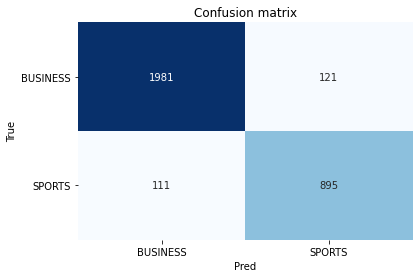

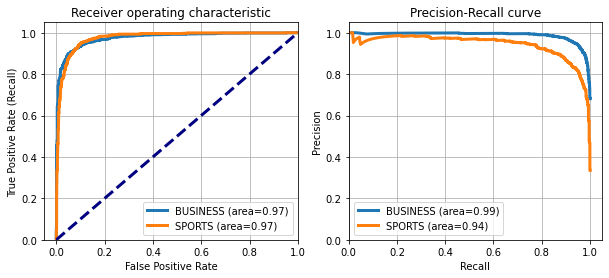

In [71]:
## test
predicted_prob = model.predict(x_val_seq)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
predicted = np.array(predicted)

from sklearn import metrics
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))

---
# <div class="alert alert-info">**10. Approach 4: Embedding (Word2Vec using Gensim framework + BERT**

## <font color='red'> Feature Engineering

**1. Create corpus with Common n-grams detectors**
Before fitting the model, the corpus needs to be transformed into a list of lists of n-grams. In this particular case, I'll try to capture unigrams ("york"), biagrams ("new york"), and triagrams ("new york city")

In [54]:
## create list of lists of unigrams
train_corpus = []
for string in df_train["text_clean"]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    train_corpus.append(lst_grams)

test_corpus = []
for string in df_test["text_clean"]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    test_corpus.append(lst_grams)

train_corpus[0:1]

[['jet',
  'chairman',
  'christoph',
  'johnson',
  'wont',
  'fine',
  'player',
  'anthem',
  'protest',
  'never',
  'want',
  'put',
  'restrict',
  'speech',
  'player']]

In [55]:
## tokenize text
tokenizer = Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(train_corpus)
## padding sequence
X_train = pad_sequences(lst_text2seq, maxlen=20, padding="post", truncating="post")

In [44]:
# conver text into integer sequences
x_tr_seq = tokenizer.texts_to_sequences(df_train['text_clean'])
x_val_seq = tokenizer.texts_to_sequences(df_test['text_clean'])

In [56]:
X_train.shape, len(train_corpus), len(dic_vocabulary)

((7250, 20), 7250, 12285)

The feature matrix X_train has a shape of 34,265 x 15 (Number of sequences x Sequences max length). Let’s visualize it:

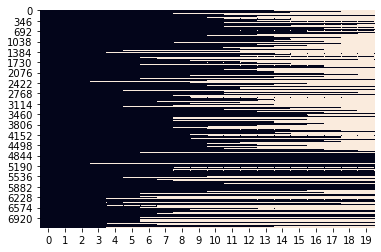

In [57]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Every text in the corpus is now an id sequence with length 15. For instance, if a text had 10 tokens in it, then the sequence is composed of 10 ids + 5 0s, which is the padding element (while the id for word not in the vocabulary is 1). Let's print how a text from the train set has been transfomed into a sequence with the padding and the vocabulary

Do the same feature engineering on the test set as well

In [58]:
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(test_corpus)

## padding sequence
X_test = pad_sequences(lst_text2seq, maxlen=20, padding="post", truncating="post")
X_test.shape, X_train.shape

((3108, 20), (7250, 20))

We've got our X_train and X_test, now we need to create the matrix of embedding that will be used as a weight matrix in the neurnal network classifier

In [59]:
len(dic_vocabulary.items()), len(dic_vocabulary)

(12285, 12285)

In [60]:
y_train = df_train['y'].values
y_test = df_test['y'].values

In [61]:
## encode y
dic_y_mapping = {n:label for n,label in  enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

In [62]:
y_train

array([1, 0, 1, ..., 0, 0, 0])

**2. Creating word embedding representation using Gensim framework**

In [63]:
## fit w2v
w2v_model = gensim.models.word2vec.Word2Vec(train_corpus, size=300, window=8, min_count=1, sg=1, iter=30)

We have our embedding model, so we can select any word from the corpus and transform it into a vector.

In [64]:
word = "cafe"
print(w2v_model[word].shape)
print(w2v_model.wv.similarity("train","travel"))

(300,)
0.23411237


## <font color='red'> Load/Train NLP

The neural network shall be structured as follows step (1) to (4):

In [65]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [75]:
# start the embedding matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word, idx in dic_vocabulary.items():
    # update the row with vector
    try:
        embeddings[idx] = w2v_model[word]
    # if word not in model then skip and the row stays all 0s
    except:
        pass

In [76]:
embeddings.shape

(12316, 300)

In [77]:
word = "data"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 262 |idx
embeddings[idx]: (300,) |vector


#### 2. Creating an Attention layer

A simple Attention layer that won’t affect the predictions but it’s going to capture the weights of each instance and allow us to build a nice explainer (it isn't necessary for the predictions, just for the explainability, so you can skip it). The Attention mechanism was presented in this paper (2014) as a solution to the problem of the sequence models (i.e. LSTM) to understand what parts of a long text are actually relevant.

In [78]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

#### 3. Neural Network Architecture

Two layers of Bidirectional LSTM to model the order of words in a sequence in both directions.

Two final dense layers that will predict the probability of each news category.

In [79]:

## input
x_in = layers.Input(shape=(20,))
## 1. embedding layer
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=20, trainable=False)(x_in)
## 2. apply attention
x = attention_layer(x, neurons=20)

## 3. 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=20, dropout=0.2))(x)

## 4. final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(2, activation='softmax')(x)

## 5. compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 20, 300)      3694800     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 20)      0           ['embedding_1[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 300, 20)      420         ['permute[0][0]']                
                                                                                              

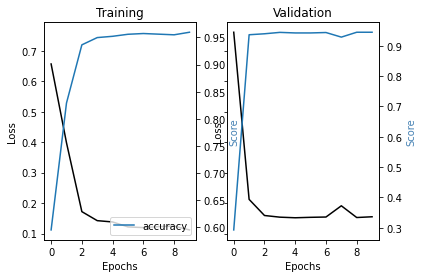

In [80]:
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)

## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Accuracy: 0.91
Auc: 0.98
Detail:
              precision    recall  f1-score   support

    BUSINESS       0.97      0.90      0.93      2106
      SPORTS       0.82      0.94      0.88      1006

    accuracy                           0.91      3112
   macro avg       0.89      0.92      0.90      3112
weighted avg       0.92      0.91      0.91      3112



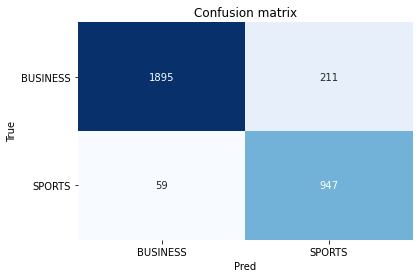

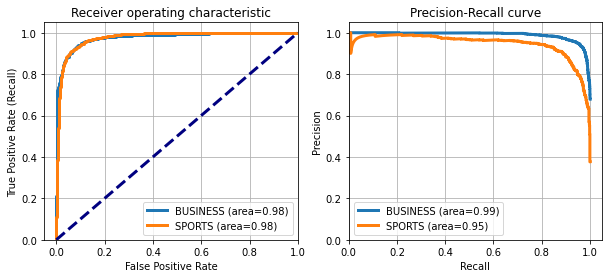

In [81]:
## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
predicted = np.array(predicted)

from sklearn import metrics

evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))

The model performs as good as the previous one, in fact, it also struggles to classify Tech news.
But is it explainable as well? Yes, it is! I put an Attention layer in the neural network to extract the weights of each word and understand how much those contributed to classify an instance. So I’ll try to use Attention weights to build an explainer (similar to the one seen in the previous section):

In [82]:
# for classification
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## select observation
i = 0
txt_instance = df_test["text"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))


True: BUSINESS --> Pred: BUSINESS | Prob: 0.99


#### show explanation

In [86]:
txt_instance

"3 Surefire Ways to Increase the Reach of Your Blog Posts. In this article I'll outline three great ways you can increase traffic to your blog and get more eyeballs reading your content."

attention


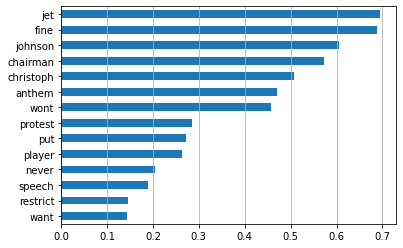

Text with highlighted words


In [117]:
### 1. preprocess input
lst_corpus = []
for string in [re.sub(r'[^\w\s]','', txt_instance.lower().strip())]:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)   
    
X_instance = kprocessing.sequence.pad_sequences(
              tokenizer.texts_to_sequences(train_corpus), maxlen=20, 
              padding="post", truncating="post")

### 2. get attention weights
layer = [layer for layer in model.layers if "attention" in layer.name][0]
print(layer.name)
func = K.function([model.input], [layer.output])
weights = func(X_instance)[0]
weights = np.mean(weights, axis=2).flatten()

### 3. rescale weights, remove null vector, map word-weight
weights = preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(np.array(weights).reshape(-1,1)).reshape(-1)
weights = [weights[n] for n,idx in enumerate(X_instance[0]) if idx  != 0]
dic_word_weigth = {word:weights[n] for n,word in 
                   enumerate(train_corpus[0]) if word in 
                   tokenizer.word_index.keys()}

### 4. barplot
if len(dic_word_weigth) > 0:
   dtf = pd.DataFrame.from_dict(dic_word_weigth, orient='index', columns=["score"])
   dtf.sort_values(by="score", 
           ascending=True).tail(20).plot(kind="barh", 
           legend=False).grid(axis='x')
   plt.show()
else:
   print("--- No word recognized ---")

### 5. produce html visualization
text = []
for word in lst_corpus[0]:
    weight = dic_word_weigth.get(word)
    if weight is not None:
         text.append('<b><span style="background-color:rgba(100,149,237,' + str(weight) + ');">' + word + '</span></b>')
    else:
         text.append(word)
text = ' '.join(text)


### 6. visualize on notebook
print("\033[1m"+"Text with highlighted words")
from IPython.core.display import display, HTML
display(HTML(text))